# Semantic Segmentation of satellite imagery using U-Net
## Step 1: Data preparation

Adapted from the [code by Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/tree/master/230_landcover_dataset_segmentation) (also see the [tutorial](https://www.youtube.com/watch?v=0W6MKZqSke8))

Dataset: https://www.kaggle.com/datasets/adrianboguszewski/landcoverai?resource=download

Tasks:

1. Read large images and corresponding masks, divide them into smaller patches and write the patches as image files to the local drive.

2. Save only images and masks where masks have a relevant amount of labels needed. In this case we are especially looking for building footprints, so images with 100% woodland don't help much.

3. Split the sorted dataset from above into train and validation datasets.

4. Move files to the correctly named directories for later use with ImageDataGenerator from keras.

To start, download the dataset and place the images and masks in the directories defined below as `dir_img` and `dir_masks`.

In [1]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [2]:
import os
import shutil
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

In [3]:
# Add the parent directory to the path to make imports work
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import helper functions from files in src folder
from src import plot, prepare_data

### Define Directories


1. Create and save all images (*tif) in /landcover_ai/images folder.
2. Create and save all masks (*tif) in /landcover_ai/masks folder.

In [4]:
# Landcover AI base path
dir_data_landcover = Path("../data/landcover_ai/")

# We suppose that the Landcover AI images are stored in the following directories
dir_img = Path(dir_data_landcover, "images")
dir_mask = Path(dir_data_landcover, "masks")

# We will store the patches in the following directories
dir_patch = Path(dir_data_landcover, "patches")
dir_patch_img = Path(dir_patch, "images")
dir_patch_mask = Path(dir_patch, "masks")
dir_patch_useful_img = Path(dir_patch, "useful/images")
dir_patch_useful_mask = Path(dir_patch, "useful/masks")

# Define file paths for the inventory
inventory_path = Path(dir_data_landcover, "inventory.csv")
inventory_short_path = Path(dir_data_landcover, "inventory_short.csv")

# Create directories if they don't exist
for dir in [dir_data_landcover, dir_img, dir_mask]:
    Path(dir).mkdir(parents=True, exist_ok=True)

In [6]:
# Count the number of images and masks
n_images = len(list(dir_img.glob("*.tif")))
n_masks = len(list(dir_mask.glob("*.tif")))

if n_images == 0:
    print("No images found")
elif n_images != n_masks:
    print("Number of images and masks do not match")
else:
    print(f"Number of images: {n_images}")
    print(f"Number of masks: {n_masks}")

Number of images: 41
Number of masks: 41


In [7]:
classes = {0: "Not classified", 1: "Building", 2: "Woodland", 3: "Water", 4: "Roads"}

### Visualize the three bands of an image.

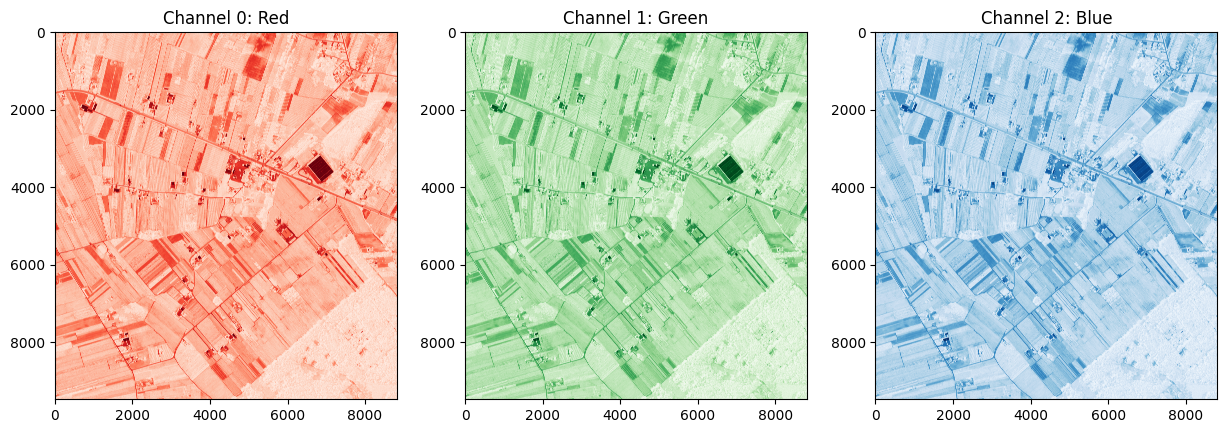

In [8]:
# Get paths of all images
img_files = [file for file in dir_img.iterdir()]

# Image with buildings
# img_path_buildings = Path(dir_img, "N-33-130-A-d-4-4.tif")

# Image with water
# img_path_water = Path(dir_img, "M-33-20-D-d-3-3.tif")

# Image with roads and buildings
img_path = Path(dir_img, "M-34-6-A-d-2-2.tif")

# Get random image from all images
# img_path = np.random.choice(img_files)


plot.plot_image_channels(img_path)



### Visualize the mask of same image above.

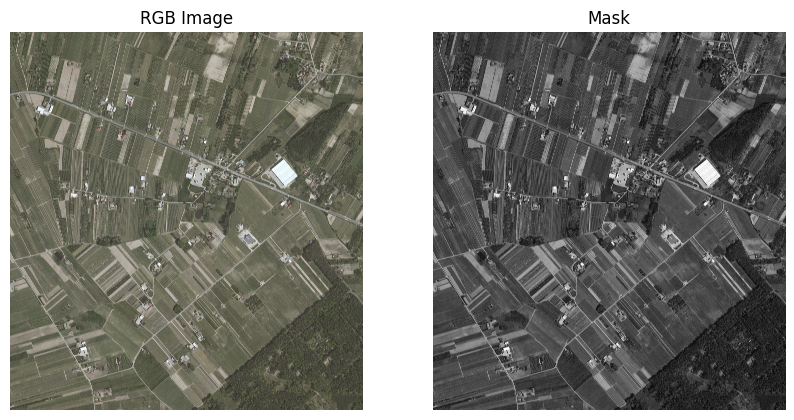

----------------------------------------------------------------
Unique values in mask: [ 41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255]


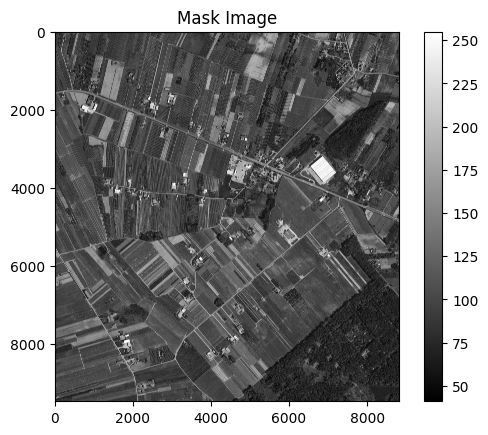

In [11]:
mask_path = Path(str(img_path).replace("/images/", "/masks/"))


# Load images
image = cv2.imread(str(img_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

# Plot both images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# RGB Image
axes[0].imshow(image)
axes[0].set_title("RGB Image")
axes[0].axis("off")

# Mask Image (Grayscale)
axes[1].imshow(mask, cmap="gray")  # Ensure grayscale display
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()

# to check mask value in array format
mask = cv2.imread(str(mask_path), 0)
unique_values = np.unique(mask)
print("----------------------------------------------------------------")
print("Unique values in mask:", unique_values)



# ------------------------------------------------------------ Extra
mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

# Display properly
plt.imshow(mask, cmap='gray')  # Use grayscale colormap
plt.colorbar()  # Add color scale
plt.title("Mask Image")
plt.show()

### Labelling according to features.

In [12]:
mask_path = Path(img_path.as_posix().replace("/images/", "/masks/"))
mask = cv2.imread(mask_path.as_posix())

# Can be checked for each channel. All channels are identical
labels, count = np.unique(mask[:, :, 0], return_counts=True)
print(
    f"Labels are:\n\n"
    f"{labels[0]}. Background: {count[0]:,} ({count[0]/np.sum(count):.2%})\n"
    f"{labels[1]}. Buildings: {count[1]:,} ({count[1]/np.sum(count):.2%})\n"
    f"{labels[2]}. Woodland: {count[2]:,} ({count[2]/np.sum(count):.2%})\n"
    f"{labels[3]}. Water: {count[3]:,} ({count[3]/np.sum(count):.2%})\n"
    f"{labels[4]}. Roads: {count[4]:,} ({count[4]/np.sum(count):.2%})"
)

Labels are:

0. Background: 68,643,142 (82.20%)
1. Buildings: 1,467,062 (1.76%)
2. Woodland: 10,910,421 (13.07%)
3. Water: 236,301 (0.28%)
4. Roads: 2,249,534 (2.69%)


### Crop large image into patch of 256 X 256

This creates a folder "data/landcover_ai/patches" containing folders:

1. "data/landcover_ai/patches/images" 
2. "data/landcover_ai/patches/masks"
3. "data/landcover_ai/patches/useful" - consists of two folders

In [13]:
# Create directories if they don't exist
for dir in [
    dir_patch,
    dir_patch_img,
    dir_patch_mask,
    dir_patch_useful_img,
    dir_patch_useful_mask,
]:
    Path(dir).mkdir(parents=True, exist_ok=True)

In [ ]:
# Run the function to create patches for images
prepare_data.create_patches(dir_img, dir_patch_img)

Patchifying image: ..\data\landcover_ai\images\M-33-20-D-c-4-2.tif
Created 1295 patches in ..\data\landcover_ai\patches\images.
Skipped 0 already existing patches.
Patchifying image: ..\data\landcover_ai\images\M-33-20-D-d-3-3.tif
Created 1295 patches in ..\data\landcover_ai\patches\images.
Skipped 0 already existing patches.
Patchifying image: ..\data\landcover_ai\images\M-33-32-B-b-4-4.tif
Created 1295 patches in ..\data\landcover_ai\patches\images.
Skipped 0 already existing patches.
Patchifying image: ..\data\landcover_ai\images\M-33-48-A-c-4-4.tif
Created 1260 patches in ..\data\landcover_ai\patches\images.
Skipped 0 already existing patches.
Patchifying image: ..\data\landcover_ai\images\M-33-7-A-d-2-3.tif
Created 1295 patches in ..\data\landcover_ai\patches\images.
Skipped 0 already existing patches.
Patchifying image: ..\data\landcover_ai\images\M-33-7-A-d-3-2.tif
Created 1295 patches in ..\data\landcover_ai\patches\images.
Skipped 0 already existing patches.
Patchifying image:

In [ ]:
# Run the function to create patches for masks
prepare_data.create_patches(dir_mask, dir_patch_mask)

## Create path inventory

In [ ]:
inventory = prepare_data.create_patch_inventory(dir_patch_mask, inventory_path, classes)

In [ ]:
inventory

## Select patches containing relevant information

### Copy patches and masks with real information to a new folder.

In [ ]:
prepare_data.select_useful_patches(
    dir_patch_img,
    dir_patch_mask,
    dir_patch_useful_img,
    dir_patch_useful_mask,
    inventory_short_path,
    classes,
)

In [ ]:
inventory_useful = prepare_data.create_patch_inventory(
    dir_patch_useful_mask,
    Path(dir_data_landcover, "inventory_useful.csv"),
    classes,
    force=True,
)

In [ ]:
# Plot a histograms in subplots for 1_pct, 2_pct, 3_pct, 4_pct in inventory_useful
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].hist(inventory_useful["1_pct"], bins=100)
axs[0].set_title(classes[1])
axs[1].hist(inventory_useful["2_pct"], bins=100)
axs[1].set_title(classes[2])
axs[2].hist(inventory_useful["3_pct"], bins=100)
axs[2].set_title(classes[3])
axs[3].hist(inventory_useful["4_pct"], bins=100)
axs[3].set_title(classes[4])

In [ ]:
# # Remove other classes from selected patches
# for file in dir_patch_useful_mask.iterdir():
#     mask = cv2.imread(file.as_posix())
#     mask[mask == 2] = 0
#     mask[mask == 3] = 0
#     mask[mask == 4] = 0
#     cv2.imwrite(file.as_posix(), mask)

### Plot random patch alongside it's mask image.

In [ ]:
# Get paths of all patches
patch_files = [file for file in dir_patch_useful_img.iterdir()]

# Randomly select one of them
patch_path = np.random.choice(patch_files)

mask_path = Path(str(patch_path).replace("/images/", "/masks/"))

# Load images from path_path randomly
image = cv2.imread(str(patch_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

# Plot both images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# RGB Image
axes[0].imshow(image)
axes[0].set_title("RGB Image")
axes[0].axis("off")

# Mask Image (Grayscale)
axes[1].imshow(mask, cmap="gray")  # Ensure grayscale display
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()


# to check mask value in array format
mask = cv2.imread(str(mask_path), 0)
unique_values = np.unique(mask)
print("Unique values of this mask:", unique_values)


### Split the data into training, validation and testing

In [ ]:
input_folder = Path(dir_patch, "useful")
output_folder = Path(dir_data_landcover, "tmp")

# Delete output_folder if it exists
if output_folder.is_dir():
    shutil.rmtree(str(output_folder))

for dir in [input_folder, output_folder]:
    Path(dir).mkdir(parents=True, exist_ok=True)

# Split with a ratio
# To only split into training and validation set, set a tuple to ratio, i.e, `(.8, .2)`.
splitfolders.ratio(
    input_folder, output=output_folder, seed=42, ratio=(0.75, 0.25), group_prefix=None
)

#### Move files to final destination.

In [ ]:
move_files = {
    "train/images/": "train_images/train/",
    "train/masks/": "train_masks/train/",
    "val/images/": "val_images/val/",
    "val/masks/": "val_masks/val/",
}

for source, dest in move_files.items():
    source = Path(output_folder, source)
    dest = Path(dir_data_landcover, dest)

    # Delete destination if it exists
    if dest.is_dir():
        shutil.rmtree(str(dest))

    # Make sure destination exists
    Path(dest).mkdir(parents=True, exist_ok=True)

    counter = 0

    for file in source.iterdir():
        if file.is_file():
            file.rename(Path(dest, file.name))
            counter += 1

    print(f"Moved {counter} files from {source} to {dest}.")

#### Remove temporary directory.

In [ ]:
files_left = 0

# Count number of files left
for file in output_folder.rglob("*"):
    if file.is_file():
        files_left += 1

if files_left == 0:
    shutil.rmtree(output_folder)
    print(f"Removed empty directory {output_folder}.")
else:
    print(f"{output_folder} not empty, did not remove.")